In [1]:
import sys
import json
from datetime import time

import numpy as np
import pandas as pd
import awkward as ak
import uproot

import xgboost
from xgboost import XGBClassifier

# import sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV

from matplotlib import pyplot as plt
import plotly.graph_objects as go

In [28]:
import ROOT

Welcome to JupyROOT 6.24/06


In [2]:
# set custom functions
plt.rcParams['axes.linewidth'] = 1.4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.minor.size'] = 2.5
plt.rcParams['xtick.minor.size'] = 4.0
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.labelsize'] = 'large'
plt.rcParams['xtick.labelsize'] = 'large'

def set_custom_alpha(col_, alpha_):
    rgb_ = to_rgba(col_)
    return (col_[0], col_[1], col_[2], alpha_)

def rgb2rgba(col_):
    _ = []
    for c in col_:
        _.append(float(c)/255.0)
    _.append(1.0)
    return tuple(_)

def getNcols(N=3, cmap_='plasma'):
    cmap = plt.get_cmap(cmap_)
    cols = cmap.colors
    arr = []
    for i in range(N):
        arr.append(cols[int(256*float(i)/float(N))])
    return arr

In [3]:
def get_arrays(tree, branch_list):
    _dict = {}
    for _br in branch_list:
        _dict[_br] = getattr(tree[_br].arrays(), _br)
    return pd.DataFrame.from_dict(_dict)

def get_input_features(df, train_list, cuts=''):
    if cuts=='': return df[train_list].to_numpy()
    _df = df[df.eval(cuts)]
    return _df[train_list].to_numpy()

In [19]:
def plot_training_history(model, category, fold):    
    results = model.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)
    fig, ax = plt.subplots(figsize=(6.6,6.6))
    ax.plot(x_axis, results['validation_0']['error'], label='Train')
    ax.plot(x_axis, results['validation_1']['error'], label='Test')
    ax.legend(fontsize=14)
    plt.ylabel('Error', fontsize=14)
    plt.xlabel('Epoch', fontsize=14)
    plt.title('category {} (iFold={})'.format(category, fold), fontsize=16)
    plt.show()

In [4]:
# scale factors for signal
scale_factors = {
    '2017':{
        'SignalNormSF': 0.72,
        'SignalSF': {
            'DS': 5.44E-4,
            'BD': 4.91E-4,
            'BU': 5.24E-4
        }
    },
    '2018':{
        'SignalNormSF': 0.86,
        'SignalSF': {
            'DS': 5.72E-04,
            'BD': 5.65E-04,
            'BU': 5.65E-04
        }
    }
}

In [5]:
training_variables = ['var_vertexKFChi2', 'var_svpvTauAngle', 'var_flightLenSig', 'var_pmin', 'var_max_cLP', 'var_max_tKink', 'var_MinD0Significance', 'var_mindca_iso', 'var_trk_relPt', 'min(Muon1_segmentCompatibility, Muon2_segmentCompatibility)', 'var_globalMuon1Id', 'var_globalMuon2Id', 'var_trackerMuonId_without_calo','var_NtracksClose', 'muon3_seg_comp_dnn', 'Muon1_BSdxySig', 'Muon2_BSdxySig', 'Muon3_BSdxySig']
spectator_variables = ['run', 'lumi', 'eventNumber', 'var_tauMassRefitted', 'category', 'threeGlobal', 'bdt_weight', 'eventWeight']

In [8]:
filename = '/eos/user/b/bjoshi/RunIITau23Mu/AnalysisTrees/Preapproval/T3MSelectionTreeInput_preapproval_iteration_2_combined_2018UL_calo_check_muonsf.root'

In [61]:
# load data
input_file = uproot.open(filename)
bkg_tree = get_arrays(input_file['TreeB'], training_variables+spectator_variables)
ds_tree = get_arrays(input_file['TreeS_Ds'], training_variables+spectator_variables)
bu_tree = get_arrays(input_file['TreeS_Bu'], training_variables+spectator_variables)
bd_tree = get_arrays(input_file['TreeS_Bd'], training_variables+spectator_variables)

In [10]:
# category A
bkg_trainX_categoryA = get_input_features(bkg_tree, training_variables,
                   'category==1 & (var_tauMassRefitted > 1.825 | var_tauMassRefitted < 1.729) & threeGlobal==0')
ds_trainX_categoryA = get_input_features(ds_tree, training_variables, 'category==1 & threeGlobal==0')
bu_trainX_categoryA = get_input_features(bu_tree, training_variables, 'category==1 & threeGlobal==0')
bd_trainX_categoryA = get_input_features(bd_tree, training_variables, 'category==1 & threeGlobal==0')

bkg_eventNumber_categoryA = get_input_features(bkg_tree, ['eventNumber'],
                   'category==1 & (var_tauMassRefitted > 1.825 | var_tauMassRefitted < 1.729) & threeGlobal==0')
ds_eventNumber_categoryA = get_input_features(ds_tree, ['eventNumber'], 'category==1 & threeGlobal==0')
bu_eventNumber_categoryA = get_input_features(bu_tree, ['eventNumber'], 'category==1 & threeGlobal==0')
bd_eventNumber_categoryA = get_input_features(bd_tree, ['eventNumber'], 'category==1 & threeGlobal==0')

bkg_trainY_categoryA = np.zeros(len(bkg_trainX_categoryA))
ds_trainY_categoryA = np.ones(len(ds_trainX_categoryA))
bu_trainY_categoryA = np.ones(len(bu_trainX_categoryA))
bd_trainY_categoryA = np.ones(len(bd_trainX_categoryA))

bkg_weights_categoryA = np.ones(len(bkg_trainX_categoryA))
ds_weights_categoryA = ds_trainY_categoryA*0.72
bu_weights_categoryA = bu_trainY_categoryA*0.14
bd_weights_categoryA = bd_trainY_categoryA*0.14

# split data into X and y
X_categoryA = np.concatenate((bkg_trainX_categoryA, ds_trainX_categoryA, bu_trainX_categoryA, bd_trainX_categoryA))
Y_categoryA = np.concatenate((bkg_trainY_categoryA, ds_trainY_categoryA, bu_trainY_categoryA, bd_trainY_categoryA))
weight_categoryA = np.concatenate((bkg_weights_categoryA, ds_weights_categoryA, bu_weights_categoryA ,bd_weights_categoryA))

In [11]:
# category B
bkg_trainX_categoryB = get_input_features(bkg_tree, training_variables,
                   'category==2 & (var_tauMassRefitted > 1.853 | var_tauMassRefitted < 1.701) & threeGlobal==0')
ds_trainX_categoryB = get_input_features(ds_tree, training_variables, 'category==2 & threeGlobal==0')
bu_trainX_categoryB = get_input_features(bu_tree, training_variables, 'category==2 & threeGlobal==0')
bd_trainX_categoryB = get_input_features(bd_tree, training_variables, 'category==2 & threeGlobal==0')

bkg_eventNumber_categoryB = get_input_features(bkg_tree, ['eventNumber'],
                   'category==2 & (var_tauMassRefitted > 1.853 | var_tauMassRefitted < 1.701) & threeGlobal==0')
ds_eventNumber_categoryB = get_input_features(ds_tree, ['eventNumber'], 'category==2 & threeGlobal==0')
bu_eventNumber_categoryB = get_input_features(bu_tree, ['eventNumber'], 'category==2 & threeGlobal==0')
bd_eventNumber_categoryB = get_input_features(bd_tree, ['eventNumber'], 'category==2 & threeGlobal==0')

bkg_trainY_categoryB = np.zeros(len(bkg_trainX_categoryB))
ds_trainY_categoryB = np.ones(len(ds_trainX_categoryB))
bu_trainY_categoryB = np.ones(len(bu_trainX_categoryB))
bd_trainY_categoryB = np.ones(len(bd_trainX_categoryB))

bkg_weights_categoryB = np.ones(len(bkg_trainX_categoryB))
ds_weights_categoryB = ds_trainY_categoryB*0.72
bu_weights_categoryB = bu_trainY_categoryB*0.14
bd_weights_categoryB = bd_trainY_categoryB*0.14

# split data into X and y
X_categoryB = np.concatenate((bkg_trainX_categoryB, ds_trainX_categoryB, bu_trainX_categoryB, bd_trainX_categoryB))
Y_categoryB = np.concatenate((bkg_trainY_categoryB, ds_trainY_categoryB, bu_trainY_categoryB, bd_trainY_categoryB))
weight_categoryB = np.concatenate((bkg_weights_categoryB, ds_weights_categoryB, bu_weights_categoryB ,bd_weights_categoryB))

In [12]:
# category C
bkg_trainX_categoryC = get_input_features(bkg_tree, training_variables,
                   'category==3 & (var_tauMassRefitted<1.677 | var_tauMassRefitted>1.877) & threeGlobal==0')
ds_trainX_categoryC = get_input_features(ds_tree, training_variables, 'category==3 & threeGlobal==0')
bu_trainX_categoryC = get_input_features(bu_tree, training_variables, 'category==3 & threeGlobal==0')
bd_trainX_categoryC = get_input_features(bd_tree, training_variables, 'category==3 & threeGlobal==0')

bkg_eventNumber_categoryC = get_input_features(bkg_tree, ['eventNumber'],
                   'category==3 & (var_tauMassRefitted<1.677 | var_tauMassRefitted>1.877) & threeGlobal==0')
ds_eventNumber_categoryC = get_input_features(ds_tree, ['eventNumber'], 'category==3 & threeGlobal==0')
bu_eventNumber_categoryC = get_input_features(bu_tree, ['eventNumber'], 'category==3 & threeGlobal==0')
bd_eventNumber_categoryC = get_input_features(bd_tree, ['eventNumber'], 'category==3 & threeGlobal==0')

bkg_trainY_categoryC = np.zeros(len(bkg_trainX_categoryC))
ds_trainY_categoryC = np.ones(len(ds_trainX_categoryC))
bu_trainY_categoryC = np.ones(len(bu_trainX_categoryC))
bd_trainY_categoryC = np.ones(len(bd_trainX_categoryC))

bkg_weights_categoryC = np.ones(len(bkg_trainX_categoryC))
ds_weights_categoryC = ds_trainY_categoryC*0.72
bu_weights_categoryC = bu_trainY_categoryC*0.14
bd_weights_categoryC = bd_trainY_categoryC*0.14

# split data into X and y
X_categoryC = np.concatenate((bkg_trainX_categoryC, ds_trainX_categoryC, bu_trainX_categoryC, bd_trainX_categoryC))
Y_categoryC = np.concatenate((bkg_trainY_categoryC, ds_trainY_categoryC, bu_trainY_categoryC, bd_trainY_categoryC))
weight_categoryC = np.concatenate((bkg_weights_categoryC, ds_weights_categoryC, bu_weights_categoryC ,bd_weights_categoryC))

In [13]:
kFolds = 5
kfold_split_by_event_categoryA = np.concatenate((bkg_eventNumber_categoryA % kFolds,
                                       ds_eventNumber_categoryA % kFolds,
                                       bu_eventNumber_categoryA % kFolds,
                                       bd_eventNumber_categoryA % kFolds))
kfold_split_by_event_categoryB = np.concatenate((bkg_eventNumber_categoryB % kFolds,
                                       ds_eventNumber_categoryB % kFolds,
                                       bu_eventNumber_categoryB % kFolds,
                                       bd_eventNumber_categoryB % kFolds))
kfold_split_by_event_categoryC = np.concatenate((bkg_eventNumber_categoryC % kFolds,
                                       ds_eventNumber_categoryC % kFolds,
                                       bu_eventNumber_categoryC % kFolds,
                                       bd_eventNumber_categoryC % kFolds))

In [15]:
xgbcvclassifiers = {'categoryA':[],
                    'categoryB':[],
                    'categoryC':[]}

In [16]:
# fit models (category A)
for ifold in range(kFolds):
    X_train = X_categoryA[kfold_split_by_event_categoryA.flatten()!=ifold,:]
    Y_train = Y_categoryA[kfold_split_by_event_categoryA.flatten()!=ifold]
    weights_train_categoryA = weight_categoryA[kfold_split_by_event_categoryA.flatten()!=ifold]
    
    X_test = X_categoryA[kfold_split_by_event_categoryA.flatten()==ifold,:]
    Y_test = Y_categoryA[kfold_split_by_event_categoryA.flatten()==ifold]
    
    model = xgboost.XGBRegressor(objective='binary:logistic',
                                 learning_rate=0.08,
                                 max_depth=3, n_estimators=100)
    history = model.fit(X_train, Y_train,
                        eval_set=[(X_train, Y_train), (X_test, Y_test)],
                        eval_metric="error", sample_weight=weights_train_categoryA)
    xgbcvclassifiers['categoryA'].append((model, history))

[0]	validation_0-error:0.191586	validation_1-error:0.188704
[1]	validation_0-error:0.186583	validation_1-error:0.184489
[2]	validation_0-error:0.186979	validation_1-error:0.184249
[3]	validation_0-error:0.186583	validation_1-error:0.18461
[4]	validation_0-error:0.175112	validation_1-error:0.173531
[5]	validation_0-error:0.171268	validation_1-error:0.171122
[6]	validation_0-error:0.175051	validation_1-error:0.173772
[7]	validation_0-error:0.171268	validation_1-error:0.171122
[8]	validation_0-error:0.171573	validation_1-error:0.171122
[9]	validation_0-error:0.174197	validation_1-error:0.172327
[10]	validation_0-error:0.173465	validation_1-error:0.171724
[11]	validation_0-error:0.17017	validation_1-error:0.169677
[12]	validation_0-error:0.166631	validation_1-error:0.164981
[13]	validation_0-error:0.161628	validation_1-error:0.162211
[14]	validation_0-error:0.16175	validation_1-error:0.159682
[15]	validation_0-error:0.162848	validation_1-error:0.161007
[16]	validation_0-error:0.160896	vali

In [17]:
# fit models (category B)
for ifold in range(kFolds):
    X_train = X_categoryB[kfold_split_by_event_categoryB.flatten()!=ifold,:]
    Y_train = Y_categoryB[kfold_split_by_event_categoryB.flatten()!=ifold]
    weights_train_categoryB = weight_categoryB[kfold_split_by_event_categoryB.flatten()!=ifold]
    
    X_test = X_categoryB[kfold_split_by_event_categoryB.flatten()==ifold,:]
    Y_test = Y_categoryB[kfold_split_by_event_categoryB.flatten()==ifold]
    
    model = xgboost.XGBRegressor(objective='binary:logistic',
                                 learning_rate=0.1,
                                 max_depth=3, n_estimators=100)
    history = model.fit(X_train, Y_train,
                        eval_set=[(X_train, Y_train), (X_test, Y_test)],
                        eval_metric="error", sample_weight=weights_train_categoryB)
    xgbcvclassifiers['categoryB'].append((model, history))

[0]	validation_0-error:0.231538	validation_1-error:0.231021
[1]	validation_0-error:0.225654	validation_1-error:0.226659
[2]	validation_0-error:0.217832	validation_1-error:0.217906
[3]	validation_0-error:0.197951	validation_1-error:0.198612
[4]	validation_0-error:0.191944	validation_1-error:0.193723
[5]	validation_0-error:0.195103	validation_1-error:0.196329
[6]	validation_0-error:0.193137	validation_1-error:0.194162
[7]	validation_0-error:0.189804	validation_1-error:0.190268
[8]	validation_0-error:0.189233	validation_1-error:0.191205
[9]	validation_0-error:0.189399	validation_1-error:0.190444
[10]	validation_0-error:0.18577	validation_1-error:0.186726
[11]	validation_0-error:0.180442	validation_1-error:0.18213
[12]	validation_0-error:0.180081	validation_1-error:0.181485
[13]	validation_0-error:0.175967	validation_1-error:0.177182
[14]	validation_0-error:0.177225	validation_1-error:0.178733
[15]	validation_0-error:0.173234	validation_1-error:0.175279
[16]	validation_0-error:0.171825	val

In [18]:
# fit models (category C)
for ifold in range(kFolds):
    X_train = X_categoryC[kfold_split_by_event_categoryC.flatten()!=ifold,:]
    Y_train = Y_categoryC[kfold_split_by_event_categoryC.flatten()!=ifold]
    weights_train_categoryC = weight_categoryC[kfold_split_by_event_categoryC.flatten()!=ifold]
    
    X_test = X_categoryC[kfold_split_by_event_categoryC.flatten()==ifold,:]
    Y_test = Y_categoryC[kfold_split_by_event_categoryC.flatten()==ifold]
    
    model = xgboost.XGBRegressor(objective='binary:logistic',
                                 learning_rate=0.05,
                                 max_depth=3, n_estimators=100)
    history = model.fit(X_train, Y_train,
                        eval_set=[(X_train, Y_train), (X_test, Y_test)],
                        eval_metric="error", sample_weight=weights_train_categoryC)
    xgbcvclassifiers['categoryC'].append((model, history))

[0]	validation_0-error:0.143973	validation_1-error:0.143023
[1]	validation_0-error:0.143864	validation_1-error:0.142943
[2]	validation_0-error:0.143993	validation_1-error:0.143063
[3]	validation_0-error:0.143576	validation_1-error:0.142863
[4]	validation_0-error:0.143576	validation_1-error:0.142823
[5]	validation_0-error:0.143556	validation_1-error:0.142662
[6]	validation_0-error:0.143457	validation_1-error:0.142622
[7]	validation_0-error:0.143308	validation_1-error:0.142341
[8]	validation_0-error:0.139914	validation_1-error:0.139173
[9]	validation_0-error:0.139705	validation_1-error:0.138932
[10]	validation_0-error:0.139785	validation_1-error:0.139013
[11]	validation_0-error:0.137711	validation_1-error:0.136566
[12]	validation_0-error:0.136619	validation_1-error:0.135202
[13]	validation_0-error:0.13511	validation_1-error:0.13436
[14]	validation_0-error:0.134644	validation_1-error:0.133638
[15]	validation_0-error:0.134733	validation_1-error:0.133398
[16]	validation_0-error:0.134376	val

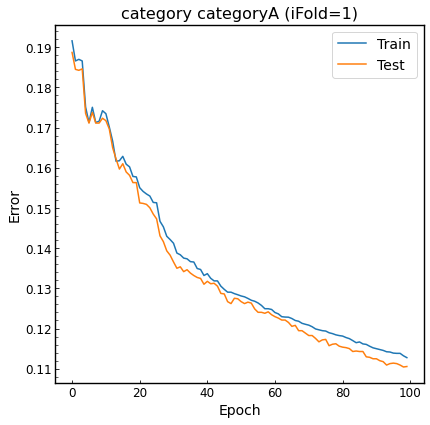

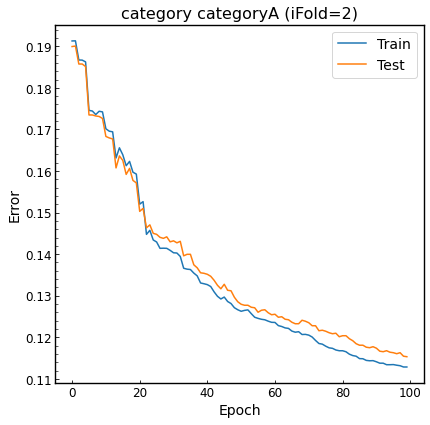

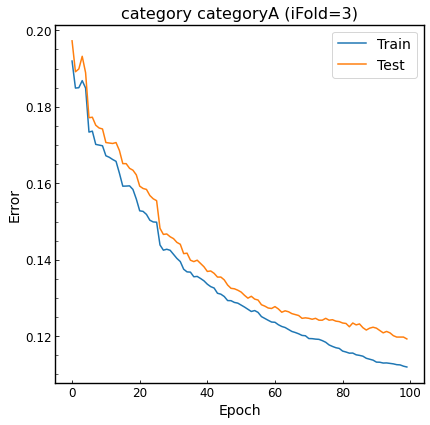

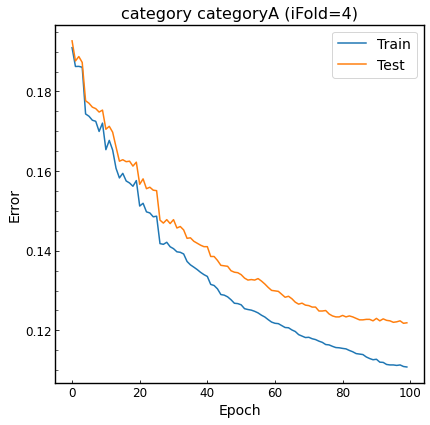

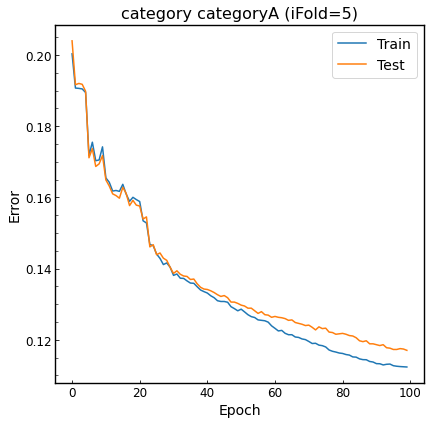

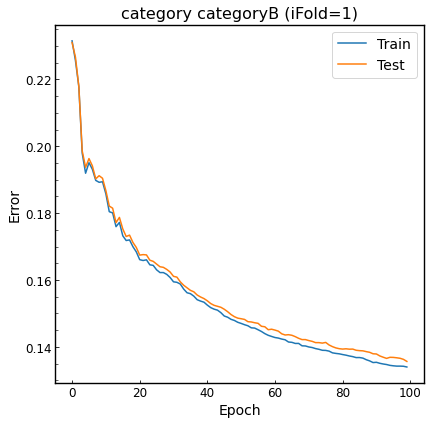

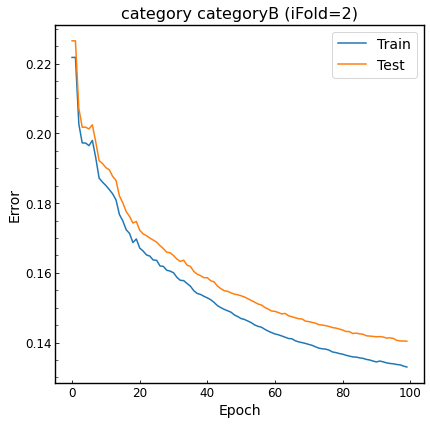

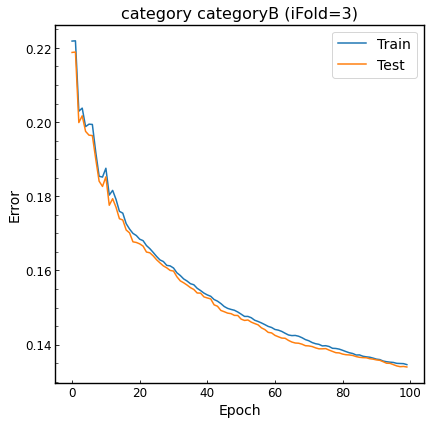

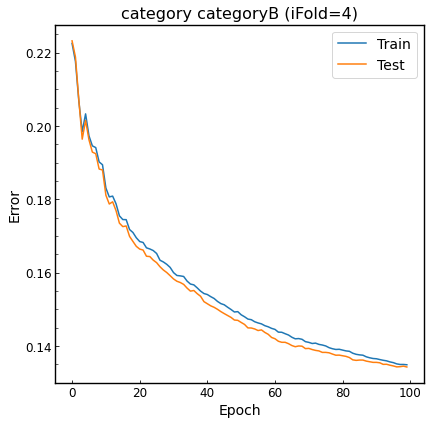

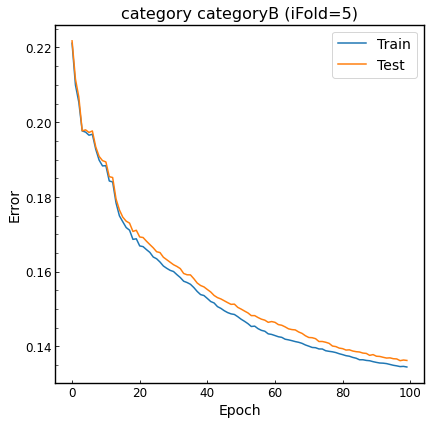

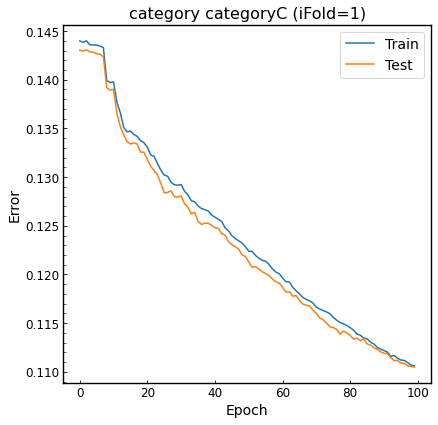

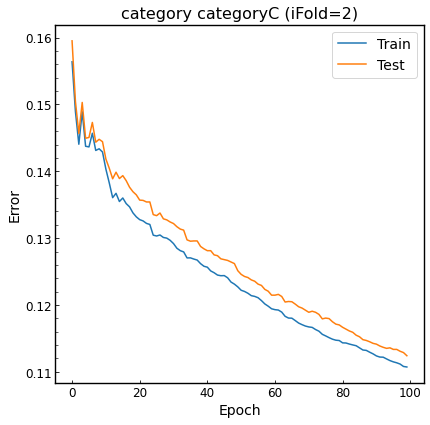

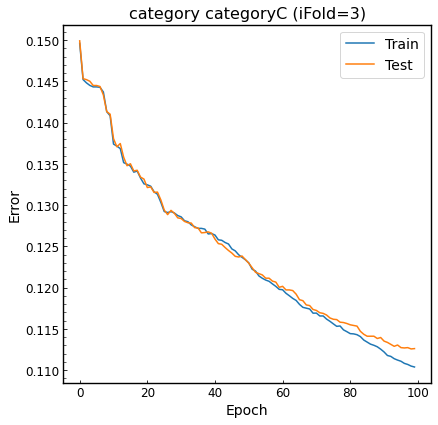

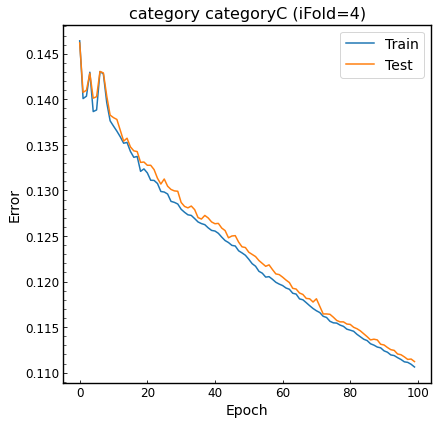

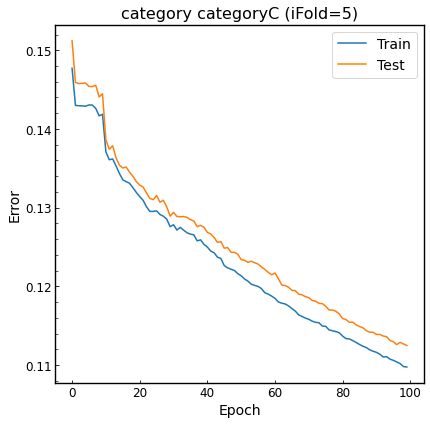

In [20]:
# plot performance 
for category_ in xgbcvclassifiers:
    for fold_ in range(kFolds):
        plot_training_history(xgbcvclassifiers[category_][fold_][0], category_, fold_+1)

In [21]:
bkg_input_X= get_input_features(bkg_tree, training_variables)
ds_input_X= get_input_features(ds_tree, training_variables)
bu_input_X= get_input_features(bu_tree, training_variables)
bd_input_X= get_input_features(bd_tree, training_variables)

In [54]:
for ic, category_ in enumerate(xgbcvclassifiers):
    for fold_ in range(kFolds):
        #bkg_tree['xgb_{}_fold{}'.format(category_, fold_)] = xgbcvclassifiers[category_][fold_][0].predict(bkg_input_X)
        bkg_tmpscores = xgbcvclassifiers[category_][fold_][0].predict(bkg_input_X)
        ds_tmpscores = xgbcvclassifiers[category_][fold_][0].predict(ds_input_X)
        bu_tmpscores = xgbcvclassifiers[category_][fold_][0].predict(bu_input_X)
        bd_tmpscores = xgbcvclassifiers[category_][fold_][0].predict(bd_input_X)
        if fold_==0 and category_=='categoryA':
            bkg_scores = (bkg_tree['eventNumber']%kFolds==fold_).to_numpy()*(bkg_tree['category']==(ic+1)).to_numpy()*(bkg_tmpscores)
            ds_scores = (ds_tree['eventNumber']%kFolds==fold_).to_numpy()*(ds_tree['category']==(ic+1)).to_numpy()*(ds_tmpscores)
            bu_scores = (bu_tree['eventNumber']%kFolds==fold_).to_numpy()*(bu_tree['category']==(ic+1)).to_numpy()*(bu_tmpscores)
            bd_scores = (bd_tree['eventNumber']%kFolds==fold_).to_numpy()*(bd_tree['category']==(ic+1)).to_numpy()*(bd_tmpscores) 
        else:
            bkg_scores += (bkg_tree['eventNumber']%kFolds==fold_).to_numpy()*(bkg_tree['category']==(ic+1)).to_numpy()*(bkg_tmpscores)
            ds_scores += (ds_tree['eventNumber']%kFolds==fold_).to_numpy()*(ds_tree['category']==(ic+1)).to_numpy()*(ds_tmpscores)
            bu_scores += (bu_tree['eventNumber']%kFolds==fold_).to_numpy()*(bu_tree['category']==(ic+1)).to_numpy()*(bu_tmpscores)
            bd_scores += (bd_tree['eventNumber']%kFolds==fold_).to_numpy()*(bd_tree['category']==(ic+1)).to_numpy()*(bd_tmpscores) 

In [62]:
bkg_tree['bdt'] = bkg_scores
ds_tree['bdt'] = ds_scores
bd_tree['bdt'] = bd_scores
bu_tree['bdt'] = bu_scores

In [63]:
bkg_tree['dataMCType'] = np.ones(len(bkg_scores))*0
ds_tree['dataMCType'] = np.ones(len(ds_scores))*1
bd_tree['dataMCType'] = np.ones(len(bd_scores))*2
bu_tree['dataMCType'] = np.ones(len(bu_scores))*3

In [64]:
ds_tree['eventWeight'] = ds_tree['eventWeight'].to_numpy()*scale_factors['2018']['SignalNormSF']*scale_factors['2018']['SignalSF']['DS']
bd_tree['eventWeight'] = bd_tree['eventWeight'].to_numpy()*scale_factors['2018']['SignalNormSF']*scale_factors['2018']['SignalSF']['BD']
bu_tree['eventWeight'] = bu_tree['eventWeight'].to_numpy()*scale_factors['2018']['SignalNormSF']*scale_factors['2018']['SignalSF']['BU']

In [65]:
combined_df = pd.concat([bkg_tree, ds_tree, bd_tree, bu_tree])[['run', 'lumi', 'eventNumber', 'category', 'dataMCType', 'eventWeight', 'var_tauMassRefitted','bdt']]

In [101]:
combined_df['category']=combined_df['category'].to_numpy()-1

In [102]:
# save file to root
#rdf = ROOT.RDF.MakeNumpyDataFrame(combined_df.to_dict()) # problems with conversion
fileName = "t3mminitree_xgb_maxdepth3_2018UL.csv";
combined_df.to_csv(fileName)
rdf = ROOT.RDF.MakeCsvDataFrame(fileName);
rdf.Snapshot("T3MMiniTree", "T3MMiniTree_xgb_maxdepth3_2018UL_twoGlobalTracker.root");

Warning in <TBranch::TBranch>: No name was given to the leaf number '0' in the leaflist of the branch ''.


In [ ]:
# optimization code
'''
param_grid_gb = {
    'gamma': [1, 2, 5, 10], 
    'learning_rate': [0.005, 0.1, 0.3, 0.5],
    'max_depth': [5],
    'n_estimators': [100],
    'reg_alpha': [0, 1, 2, 5, 10, 50],
    'reg_lambda': [1, 2, 5, 10, 50]
}
gb = xgboost.XGBRegressor()
mse_grid = GridSearchCV(estimator = gb, param_grid = param_grid_gb, scoring = 'neg_mean_squared_error', cv = 5, verbose = 1)
history = mse_grid.fit(X_train, Y_train,
                    eval_set=[(X_train, Y_train), (X_test, Y_test)])
'''

<Figure size 432x288 with 0 Axes>

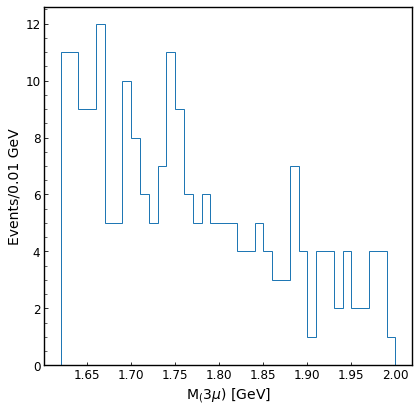

In [115]:
#plot category C
plt.clf()
plt.figure(figsize=(6.6,6.6))
plt.hist(bkg_tree[((bkg_tree['category']==3) &
                (bkg_tree['bdt']>0.9) &
                (bkg_tree['bdt']<1.0))]['var_tauMassRefitted'],
                bins=38, range=(1.62, 2.00), histtype='step')
plt.xlabel('M$_(3\mu)$ [GeV]', fontsize=14)
plt.ylabel('Events/0.01 GeV', fontsize=14)
plt.show()

<Figure size 432x288 with 0 Axes>

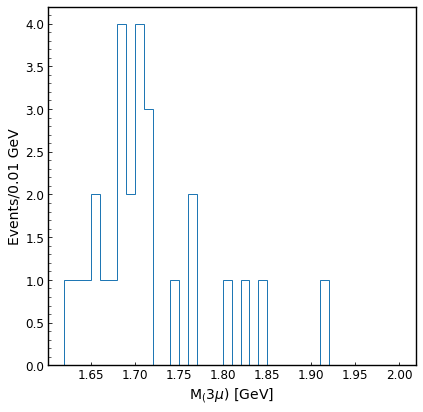

In [100]:
#plot category A
plt.clf()
plt.figure(figsize=(6.6,6.6))
plt.hist(bkg_tree[((bkg_tree['category']==1) &
                (bkg_tree['bdt']>0.97) &
                (bkg_tree['bdt']<1.0))]['var_tauMassRefitted'],
                bins=38, range=(1.62, 2.00), histtype='step')
plt.xlabel('M$_(3\mu)$ [GeV]', fontsize=14)
plt.ylabel('Events/0.01 GeV', fontsize=14)
plt.show()